#### Check if GPU is available
If you are running this in gsds server, follow the instruction below to run jupyter notebook with GPU.

https://gsds.gitbook.io/gsds/for-beginners/slurm

In [4]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Install requried packages if not installed in your environment

In [1]:
# !pip install wikipedia
# !pip install transformers
# !pip install -q datasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.0 MB/s eta 0:00:00
  Obtaining dependency information for soupsieve>1.2 from https://files.pythonhosted.org/packages/4c/f3/038b302fdfbe3be7da016777069f26ceefe11a681055ea1f7817546508e3/soupsieve-2.5-py3-none-any.whl.metadata
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=956aa67cdf15022e21c5c55da59216b2ccce51a50da71bd5335ae9d40b01bcf3
  Stored in directory: /home/jwjung/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


#### Run this cell before you start

In [5]:
from matplotlib import pyplot as plt
from collections import OrderedDict
import wikipedia as wiki
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Inference using a pre-trained Question Answering model 

In this problem, we will utilize a pre-trained BERT(Bidirectional Encoder Representations from Transformers) model for question answering. BERT excels in this task by leveraging its contextual understanding of language, employing techniques such as tokenization, segment embeddings, positional embeddings, and multi-head self-attention to capture intricate relationships between words. During the inference phase, the model predicts answer spans in a passage based on its extensive pre-trained knowledge and fine-tuned task-specific understanding. 

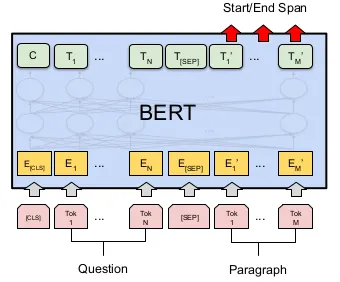

There are various approaches to employing deep learning models for question answering, and we will explore the intricacies of this task in upcoming lectures. For now, prepare for a hands-on journey into loading a pre-trained BERT model from Hugging Face, which encodes questions and context together and answers by selecting a span in the given context. The model's output includes scores for the start and end positions of the answer span. Follow the instructions in the provided Jupyter notebook to complete the code.

**(a)** Load the pre-trained model and tokenizer and complete the `__init__` function. **(2 pts)**

**(b)** Implement the `tokenize` function to encode the question and context. **(6 pts)**

**(c)** Complete the `generateAnswer` function for inference. **(12 pts)**

**(d, bonus)** Add a condition that ensures the end position comes after the start position in your inference code. **(4 pts)**

In [14]:
class QAmodel:
    def __init__(self, model_path):
        self.model_path = model_path

        ### YOUR CODE HERE (~2 lines)
        ### TODO:
        ### Load a tokenizer and question answering model from hugging face and save them in self.tokenizer and self.model
        ### Hint: you can refer to the following document and use given model_path
        ### https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForQuestionAnswering
        
        self.tokenizer =  AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)

        ### END YOUR CODE
        self.max_seq_len = self.model.config.max_position_embeddings
        self.splitted = False

    def tokenize(self, question, context):
        ### YOUR CODE HERE (~5 lines)
        ### TODO:
        ### 1. Encode the question and context by passing into the loaded tokenizer and save it to self.inputs
        ###     Hint: you have to return 'token_type_ids' in order to be used in self.split()
        ###     Hint: you can refer to the following document for tokenizer
        ###           https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html
        ### 2. If input length exceeds the maximum sequence length, the input context should be splitted. Mark self.splitted True if it is splitted.
        ###     Hint: use given self.max_seq_len and self.split()
        ### Hint: this function will return nothing
        
        self.inputs = self.tokenizer(question, context, return_tensors='pt')
        if len(context) > self.max_seq_len:
            self.inputs = self.split()
            self.splitted = True
        


        ### END YOUR CODE

    def split(self):
        # this function is to split the input context if the length exceeds the maximum sequence length
        question_mask = self.inputs['token_type_ids'].lt(1)
        question_size = torch.masked_select(self.inputs['input_ids'], question_mask).size()[0]
        split_size = self.max_seq_len - question_size - 1

        inputs_splitted = OrderedDict()
        for key, item in self.inputs.items():
            question = torch.masked_select(item, question_mask)
            context = torch.masked_select(item, ~question_mask)
            context_splitted = torch.split(context, split_size)

            for i, context in enumerate(context_splitted):
                if i not in inputs_splitted:
                    inputs_splitted[i] = {}
                input_item = torch.cat((question, context))
                if i != len(context_splitted) - 1:
                    if key == 'input_ids':
                        input_item = torch.cat((input_item, torch.tensor([102])))
                    else:
                        input_item = torch.cat((input_item, torch.tensor([1])))
                inputs_splitted[i][key] = torch.unsqueeze(input_item, dim=0)

        return inputs_splitted

    def generateAnswer(self):
        if self.splitted:
            answer = ''
            for i, input_item in self.inputs.items():

                ### YOUR CODE HERE (~6 lines)
                ### TODO:
                ### Get answer from each of the splitted contexts. 
                ### Remember that this model predicts answer by span selection. The output will contain scores for start and end position. 
                ### Hint: Use torch.argmax and given self.convert_to_string function
                ### Hint: You should note that in a Python index [A:B], it includes the element at index A and excludes the element at index B.
                ### Hint: you can refer to the following document 
                input_ids = input_item['input_ids']
                output = self.model(input_ids)
                start_logit, end_logit = output['start_logits'], output['end_logits']
                start_idx = torch.argmax(start_logit)
                end_idx = torch.argmax(end_logit)
                ans = self.convert_to_string(input_item['input_ids'][0][start_idx : end_idx+1])
            
                ### END YOUR CODE
                if ans != '[CLS]':
                    answer += ans + ", "
            return answer
        
        else:
            ### YOUR CODE HERE (~6 lines)
            ### TODO:
            ### Get answer from self.inputs.
            ### Hint: use the same approach you made in the previous question
            output = self.model(self.inputs['input_ids'])
            start_logit, end_logit = output['start_logits'], output['end_logits']
            start_idx = torch.argmax(start_logit)
            end_idx = torch.argmax(end_logit)
            ans = self.convert_to_string(input_item['input_ids'][0][start_idx : end_idx+1])
            
            ### END YOUR CODE
            return answer

    def convert_to_string(self, input_ids):
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
        answer = self.tokenizer.convert_tokens_to_string(tokens)
        return answer

### Inference

Now let's use the pre-trained model to generate answer to the questions. 

For context, we will use Wikipedia, a Python library that makes it easy to access and parse data from Wikipedia.
You can refer to [here](https://wikipedia.readthedocs.io/en/latest/code.html#api) for use of the library.

In [15]:
questions = [
    'Who is the author of Harry Potter and the Goblet of Fire?',
    'Where was the 2010 world cup played?'
    ]

model_path = "deepset/bert-base-cased-squad2"
model = QAmodel(model_path)

for question in questions:
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0])
    print(f"Top wiki result: {page}")
    context = page.content

    model.tokenize(question, context)
    answer = model.generateAnswer()
    print(f"Answer: {answer}")
    print("---------------------------------------------------------------------------------")

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: Who is the author of Harry Potter and the Goblet of Fire?
Top wiki result: <WikipediaPage 'Harry Potter and the Goblet of Fire'>


Token indices sequence length is longer than the specified maximum sequence length for this model (3489 > 512). Running this sequence through the model will result in indexing errors


Answer: J. K. Rowling and the fourth novel in the Harry Potter series. It follows Harry Potter, a wizard in his fourth year at Hogwarts School of Witchcraft and Wizardry, and the mystery surrounding the entry of Harry ' s name into the Triwizard Tournament, in which he is forced to compete. The book was published in the United Kingdom by Bloomsbury and in the United States by Scholastic. In both countries, the release date was 8 July 2000. This was the first time a book in the series was published in both countries at the same time. The novel won a Hugo Award, the only Harry Potter novel to do so, in 2001. The book was adapted into a film, released worldwide on 18 November 2005, and a video game by Electronic Arts. = = Plot = = Over the summer, the Weasleys invite Harry Potter to attend the Quidditch World Cup final, played between Bulgaria and the Republic of Ireland. The match ends in a victory for the Irish, but the campsite is attacked by Voldemort ' s former followers called the D